# 神经网络
可以使用torch.nn包来构建神经网络.

你已知道autograd包,nn包依赖autograd包来定义模型并求导.一个nn.Module包含各个层和一个faward(input)方法,该方法返回output.
下图是手写体识别的结构图：
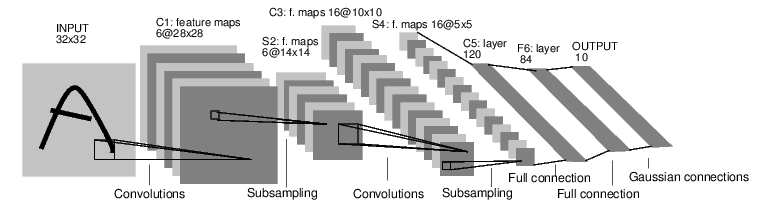

他是一个简单的前馈神经网络,它接受一个输入,然后一层接着一层的输入,直到最后得到结果.

神经网络的典型训练过程如下:

1.定义神经网络模型,它有一些可学习的参数(或者权重);
2.在数据集上迭代;
3.通过神经网络处理输入;
4.计算损失(输出结果和正确值的差距大小)
5.将梯度反向传播会网络的参数;
6.更新网络的参数,主要使用如下简单的更新原则:
            weight = weight - learning_rate * gradient

# CNN模型构建

"""Pytorch中神经网络模块化接口nn的了解"""
"""
torch.nn是专门为神经网络设计的模块化接口。nn构建于autograd之上，可以用来定义和运行神经网络。
nn.Module是nn中十分重要的类,包含网络各层的定义及forward方法。
定义自已的网络：
    需要继承nn.Module类，并实现forward方法。
    一般把网络中具有可学习参数的层放在构造函数__init__()中，
    不具有可学习参数的层(如ReLU)可放在构造函数中，也可不放在构造函数中(而在forward中使用nn.functional来代替)
    
    只要在nn.Module的子类中定义了forward函数，backward函数就会被自动实现(利用Autograd)。
    在forward函数中可以使用任何Variable支持的函数，毕竟在整个pytorch构建的图中，是Variable在流动。还可以使用
    if,for,print,log等python语法.
    
    注：Pytorch基于nn.Module构建的模型中，只支持mini-batch的Variable输入方式，
    比如，只有一张输入图片，也需要变成 N x C x H x W 的形式：
    
    input_image = torch.FloatTensor(1, 28, 28)
    input_image = Variable(input_image)
    input_image = input_image.unsqueeze(0)   # 1 x 1 x 28 x 28
    
"""

In [57]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #复制并使用Net的父类的初始化方法，即先运行nn.Module的初始化函数
         # 1 input image channel, 6 output channels, 5*5 square convolution kernel
        # 定义conv1函数的是图像卷积函数：输入为图像（1个频道，即灰度图）,输出为 6张特征图, 卷积核为5x5正方形

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        ## 定义fc1（fullconnect）全连接函数1为线性函数：y = Wx + b，并将16*5*5个节点连接到120个节点上。
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
#定义该神经网络的向前传播函数，该函数必须定义，一旦定义成功，向后传播函数也会自动生成（autograd）
    def forward(self, x):
        # max pooling over a (2, 2) window
        # 输入x经过卷积conv1之后，经过激活函数ReLU，使用2x2的窗口进行最大池化Max pooling，然后更新到x。
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #view函数将张量x变形成一维的向量形式，总特征数并不改变，为接下来的全连接作准备。
        x = x.view(-1, self.num_flat_features(x))
        
        #输入x经过全连接1，再经过ReLU激活函数，然后更新x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    #使用num_flat_features函数计算张量x的总特征量（把每个数字都看出是一个特征，即特征总量），比如x是4*2*2的张量，那么它的特征总量就是16。
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        # 这里为什么要使用[1:],是因为pytorch只接受批输入，也就是说一次性输入好几张图片，那么输入数据张量的维度自然上升到了4维。【1:】让我们把注意力放在后3维上面
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


只需定义forward函数,backward函数(计算梯度)在使用autograd时自动为你创建.你可以在forward函数中使用Tensor的任何操作.

net.parameters()返回模型需要学习的参数

In [58]:
params = list(net.parameters())
print(len(params))
for param in params:
    print(param.size())
    

10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


orward的输入和输出都是autograd.Variable.注意:这个网络(LeNet)期望的输入大小是32*32.如果使用MNIST数据集来训练这个网络,请把图片大小重新调整到32*32.

In [59]:
input = Variable(torch.randn(1,1,32,32))
print(input)
out = net(input)
print(out)

tensor([[[[ 0.6754,  0.5289, -0.1681,  ...,  0.3581, -0.2755, -0.1741],
          [ 0.9727,  1.0448,  0.6708,  ..., -1.1157, -0.2129, -0.5226],
          [-0.1384,  0.2897,  0.7921,  ...,  1.7863,  0.2899,  0.2231],
          ...,
          [-0.7052, -0.8658,  1.7972,  ..., -0.6436,  0.6446, -0.3966],
          [-0.9846, -0.7667,  2.5796,  ...,  1.4428,  2.1301, -1.1939],
          [-0.6626,  0.7241,  1.0766,  ...,  0.9399,  0.1397,  0.2600]]]])
tensor([[ 0.0507,  0.0679, -0.0316, -0.0745,  0.0134, -0.1492, -0.0418, -0.0355,
          0.0660, -0.0086]], grad_fn=<AddmmBackward>)


In [60]:
#将所有参数的梯度缓存清零,然后进行随机梯度的的反向传播.
net.zero_grad()
out.backward(torch.randn(1,10))

注意

torch.nn 只支持小批量输入,整个torch.nn包都只支持小批量样本,而不支持单个样本
例如,nn.Conv2d将接受一个4维的张量,每一维分别是sSamples nChannels Height Width(样本数\通道数*高*宽).
如果你有单个样本,只需使用input.unsqueeze(0)来添加其它的维数.

回顾

torch.Tensor-一个多维数组
autograd.Variable-包装一个Tensor,记录在其上执行过的操作.除了拥有Tensor拥有的API,还有类似backward()的API.也保存关于这个向量的梯度.
nn.Module-神经网络模块.封装参数,移动到GPU上运行,导出,加载等
nn.Parameter-一种变量,当把它赋值给一个Module时,被自动的注册为一个参数.
autograd.Function-实现一个自动求导操作的前向和反向定义,每个变量操作至少创建一个函数节点,(Every Variable operation, creates at least a single Function node, that connects to functions that created a Variable and encodes its history.)

# 损失函数
一个损失函数接受一对(output, target)作为输入(output为网络的输出,target为实际值),计算一个值来估计网络的输出和目标值相差多少.

在nn包中有几种不同的损失函数.
一个简单的损失函数是:nn.MSELoss,他计算网络的输出和目标值之间的均方误差.

In [61]:
out = net(input)
target = Variable(torch.randn(10))
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(out,target)
print(loss)

tensor(0.9166, grad_fn=<MseLossBackward>)


In [62]:
loss.grad_fn

In [63]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

为了反向传播误差,我们所需做的是调用loss.backward().需要清除已存在的梯度,否则梯度将被累加到已存在的梯度.

现在,我们将调用loss.backward(),并查看conv1层的偏置项在反向传播前后的梯度.

In [64]:
net.zero_grad() #清楚梯度

print('conv1.bias.grad before backward\n', net.conv1.bias.grad)
loss.backward()
print('conv1.bias.grad after backward\n',net.conv1.bias.grad)

conv1.bias.grad before backward
 tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
 tensor([-0.0030,  0.0165, -0.0144, -0.0036, -0.0181,  0.0102])


更新权重
实践中最简单的更新规则是随机梯度下降(SGD)
            weight = weight - learning_rate * gradient

In [65]:
lr = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * lr)
    

In [66]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update